In [9]:
# Cell 1: Import cơ bản
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim
import pytesseract
import os
import matplotlib.pyplot as plt
from difflib import SequenceMatcher

In [10]:
pytesseract.pytesseract.tesseract_cmd = r'D:\Apps\Tesseract-OCR\tesseract.exe'

In [11]:
# Cell 2: Core Algorithm - Đơn giản và hiệu quả
class VisualTester:
    """Giải pháp kiểm thử giao diện đơn giản"""
    
    def preprocess(self, img_path):
        """Tiền xử lý ảnh chuẩn"""
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            return None
        # Resize và khử nhiễu
        img = cv2.resize(img, (800, 600))
        img = cv2.fastNlMeansDenoising(img)
        return img
    
    def compare_visual(self, img1_path, img2_path):
        """So sánh visual bằng SSIM"""
        img1 = self.preprocess(img1_path)
        img2 = self.preprocess(img2_path)
        
        if img1 is None or img2 is None:
            return 0
        
        # Tính SSIM score
        score = ssim(img1, img2)
        return score * 100  # Convert to percentage
    
    def compare_text(self, img1_path, img2_path):
        """So sánh text bằng OCR"""
        try:
            text1 = pytesseract.image_to_string(cv2.imread(img1_path)).strip()
            text2 = pytesseract.image_to_string(cv2.imread(img2_path)).strip()
            
            # Text similarity
            similarity = SequenceMatcher(None, text1, text2).ratio()
            return similarity * 100
        except:
            return 0
    
    def test_similarity(self, img1_path, img2_path, show_details=True):
        """Main testing function"""
        visual_score = self.compare_visual(img1_path, img2_path)
        text_score = self.compare_text(img1_path, img2_path)
        
        # Combined score (70% visual, 30% text)
        combined_score = (visual_score * 0.7) + (text_score * 0.3)
        
        # Decision
        is_similar = combined_score > 80
        
        if show_details:
            print(f"Testing: {os.path.basename(img1_path)} vs {os.path.basename(img2_path)}")
            print(f"Visual: {visual_score:.1f}%")
            print(f"Text: {text_score:.1f}%")
            print(f"Combined: {combined_score:.1f}%")
            print(f"Result: {'SIMILAR' if is_similar else 'DIFFERENT'}")
            print()
        
        return {
            'visual': visual_score,
            'text': text_score,
            'combined': combined_score,
            'similar': is_similar
        }

# Initialize tester
tester = VisualTester()
print("VisualTester ready!")

VisualTester ready!


In [12]:
# Cell 3: Quick Test Function
def quick_test(img1, img2):
    """Test nhanh 2 ảnh"""
    if not os.path.exists(img1):
        print(f"Not found: {img1}")
        return
    if not os.path.exists(img2):
        print(f"Not found: {img2}")
        return
    
    result = tester.test_similarity(img1, img2)
    return result

In [13]:
# Cell 4: Batch Testing với Dataset
def evaluate_algorithm(test_cases):
    """
    Đánh giá thuật toán trên nhiều test cases
    
    test_cases format:
    [
        ("original1.jpg", "similar1.jpg", "similar"),
        ("original1.jpg", "different1.jpg", "different"),
        ...
    ]
    """
    total = len(test_cases)
    correct = 0
    results = []
    
    print(f"Testing {total} cases...")
    print("="*50)
    
    for i, (img1, img2, expected) in enumerate(test_cases, 1):
        print(f"Test {i}/{total}: ", end="")
        
        result = tester.test_similarity(img1, img2, show_details=False)
        predicted = "similar" if result['similar'] else "different"
        is_correct = predicted == expected
        
        if is_correct:
            correct += 1
            
        print(f"{os.path.basename(img2)} -> {predicted} ({'✅' if is_correct else '❌'})")
        
        results.append({
            'test_id': i,
            'expected': expected,
            'predicted': predicted,
            'score': result['combined'],
            'correct': is_correct
        })
    
    accuracy = (correct / total) * 100
    
    print("\nRESULTS:")
    print(f"   Total tests: {total}")
    print(f"   Correct: {correct}")
    print(f"   Accuracy: {accuracy:.1f}%")
    
    return results, accuracy

In [14]:
# Cell 5: Find Best Threshold
def find_best_threshold(test_cases):
    """Tìm threshold tối ưu"""
    thresholds = [70, 75, 80, 85, 90, 95]
    best_accuracy = 0
    best_threshold = 80
    
    print("Finding optimal threshold...")
    
    for threshold in thresholds:
        correct = 0
        
        for img1, img2, expected in test_cases:
            result = tester.test_similarity(img1, img2, show_details=False)
            predicted = "similar" if result['combined'] > threshold else "different"
            if predicted == expected:
                correct += 1
        
        accuracy = (correct / len(test_cases)) * 100
        print(f"   Threshold {threshold}%: {accuracy:.1f}% accuracy")
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_threshold = threshold
    
    print(f"\nBest threshold: {best_threshold}% (Accuracy: {best_accuracy:.1f}%)")
    return best_threshold, best_accuracy

In [15]:
# Cell 6: Simple Visualization
def plot_results(results):
    """Vẽ biểu đồ kết quả đơn giản"""
    scores = [r['score'] for r in results]
    correct = [r['correct'] for r in results]
    
    # Score distribution
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    colors = ['green' if c else 'red' for c in correct]
    plt.scatter(range(len(scores)), scores, c=colors, alpha=0.7)
    plt.axhline(y=80, color='blue', linestyle='--', label='Threshold')
    plt.xlabel('Test Case')
    plt.ylabel('Combined Score (%)')
    plt.title('Test Results (Green=Correct, Red=Wrong)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.hist(scores, bins=10, alpha=0.7, color='blue', edgecolor='black')
    plt.axvline(x=80, color='red', linestyle='--', label='Threshold')
    plt.xlabel('Combined Score (%)')
    plt.ylabel('Frequency')
    plt.title('Score Distribution')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

📋 First, setup MUD dataset by running:
python dataset_mud.py

🚀 Starting MUD Dataset evaluation...
🎯 MUD DATASET VISUAL TESTING EVALUATION
📱 Real Android UI Screenshots from Google Research
Found 100 original images
original_1: 6 variants
original_10: 6 variants
original_100: 6 variants
original_11: 6 variants
original_12: 6 variants
original_13: 6 variants
original_14: 6 variants
original_15: 6 variants
original_16: 6 variants
original_17: 6 variants
original_18: 6 variants
original_19: 6 variants
original_2: 6 variants
original_20: 6 variants
original_21: 6 variants
original_22: 6 variants
original_23: 6 variants
original_24: 6 variants
original_25: 6 variants
original_26: 6 variants
original_27: 6 variants
original_28: 6 variants
original_29: 6 variants
original_3: 6 variants
original_30: 6 variants
original_31: 6 variants
original_32: 6 variants
original_33: 6 variants
original_34: 6 variants
original_35: 6 variants
original_36: 6 variants
original_37: 6 variants
original_38: 6 var

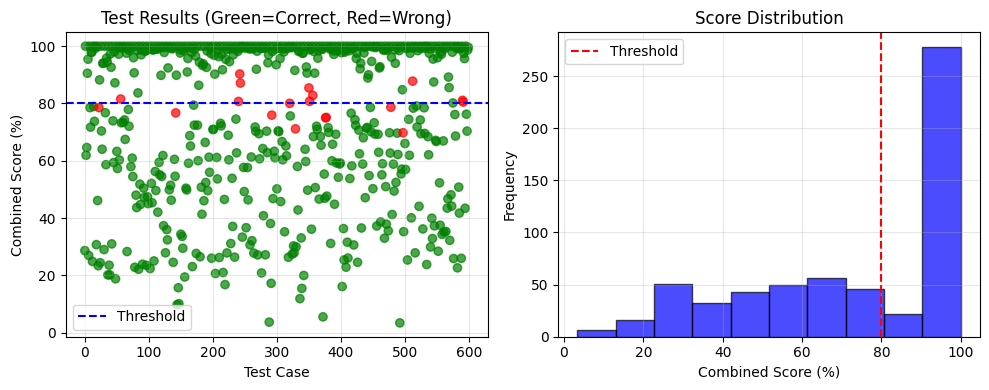


🔧 OPTIMIZING THRESHOLD FOR MUD DATASET...
Finding optimal threshold...
   Threshold 70%: 90.2% accuracy
   Threshold 75%: 95.5% accuracy
   Threshold 80%: 96.8% accuracy
   Threshold 85%: 97.5% accuracy
   Threshold 90%: 96.5% accuracy


KeyboardInterrupt: 

In [ ]:
# Cell 7: Thêm function auto_generate_test_cases_v3 và run MUD evaluation

import os
import re

def auto_generate_test_cases_v3(original_dir, variant_dir):
    """Tự động tạo test cases cho 6 loại variants"""
    test_cases = []
    
    # Mapping variants to expected results
    variant_mapping = {
        'identical': 'similar',           # 100% giống
        'minor_changes': 'similar',       # Thay đổi nhỏ
        'text_changes': 'similar',        # Text thay đổi nhưng layout giống
        'layout_changes': 'different',    # Layout thay đổi
        'major_changes': 'different',     # Thay đổi lớn
        'completely_different': 'different'  # Hoàn toàn khác
    }
    
    if not os.path.exists(original_dir) or not os.path.exists(variant_dir):
        print("Thư mục không tồn tại!")
        return test_cases
    
    # Lấy danh sách ảnh original
    original_files = [f for f in os.listdir(original_dir) 
                     if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    print(f"Found {len(original_files)} original images")
    
    for original_file in original_files:
        # Extract số từ tên file
        match = re.search(r'original_(\d+)', original_file)
        if not match:
            continue
        
        original_num = match.group(1)
        original_path = os.path.join(original_dir, original_file)
        
        # Tìm thư mục variant tương ứng
        variant_folder = os.path.join(variant_dir, f"original_{original_num}")
        
        if not os.path.exists(variant_folder):
            print(f"Missing variant folder: original_{original_num}")
            continue
        
        # Lấy các variant trong thư mục
        variant_files = [f for f in os.listdir(variant_folder) 
                        if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        print(f"original_{original_num}: {len(variant_files)} variants")
        
        for variant_file in variant_files:
            variant_path = os.path.join(variant_folder, variant_file)
            
            # Phân loại dựa trên tên file
            variant_name = variant_file.split('.')[0]  # Remove extension
            expected = variant_mapping.get(variant_name, "unknown")
            
            test_cases.append((original_path, variant_path, expected))
    
    return test_cases

def run_mud_evaluation():
    """Chạy evaluation với MUD Dataset"""
    
    print("🎯 MUD DATASET VISUAL TESTING EVALUATION")
    print("📱 Real Android UI Screenshots from Google Research")
    print("="*60)
    
    if not os.path.exists("Pictures_VisualTesting"):
        print("❌ Pictures_VisualTesting folder not found!")
        print("💡 Run dataset_mud.py first!")
        return None, None, None
    
    original_dir = "Pictures_VisualTesting/original_image/"
    variant_dir = "Pictures_VisualTesting/variant_image/"
    
    test_cases = auto_generate_test_cases_v3(original_dir, variant_dir)
    
    if not test_cases:
        print("❌ No test cases found!")
        return None, None, None
    
    # Phân loại theo 6 categories
    categories = {
        'identical': [tc for tc in test_cases if 'identical' in tc[1]],
        'minor_changes': [tc for tc in test_cases if 'minor_changes' in tc[1]],
        'text_changes': [tc for tc in test_cases if 'text_changes' in tc[1]],
        'layout_changes': [tc for tc in test_cases if 'layout_changes' in tc[1]],
        'major_changes': [tc for tc in test_cases if 'major_changes' in tc[1]],
        'completely_different': [tc for tc in test_cases if 'completely_different' in tc[1]]
    }
    
    print(f"\n📊 Generated {len(test_cases)} test cases from MUD dataset:")
    for category, cases in categories.items():
        print(f"   🔹 {category}: {len(cases)} cases")
    
    print(f"\n🎯 TESTING ON REAL ANDROID UI SCREENSHOTS")
    print("="*60)
    
    # Chạy evaluation
    results, overall_accuracy = evaluate_algorithm(test_cases)
    
    # Phân tích chi tiết theo category
    print(f"\n📈 DETAILED ANALYSIS BY CATEGORY:")
    for category, cases in categories.items():
        if not cases:
            continue
            
        category_results = []
        for case in cases:
            for result in results:
                test_case = test_cases[result['test_id']-1]
                if test_case[1] == case[1]:
                    category_results.append(result)
                    break
        
        if category_results:
            correct = sum(1 for r in category_results if r['correct'])
            accuracy = correct / len(category_results) * 100
            avg_score = sum(r['score'] for r in category_results) / len(category_results)
            
            print(f"   📱 {category.upper()}:")
            print(f"      ✅ Accuracy: {accuracy:.1f}%")
            print(f"      📊 Avg Score: {avg_score:.1f}%")
            print(f"      📋 Cases: {len(category_results)}")
    
    # Visualization
    plot_results(results)
    
    # Threshold optimization 
    print(f"\n🔧 OPTIMIZING THRESHOLD FOR MUD DATASET...")
    best_threshold, best_accuracy = find_best_threshold(test_cases)
    
    print(f"\n🏆 MUD EVALUATION COMPLETED!")
    print(f"📊 FINAL RESULTS:")
    print(f"   💯 Overall Accuracy: {overall_accuracy:.1f}%")
    print(f"   🎯 Best Threshold: {best_threshold}%") 
    print(f"   📈 Optimized Accuracy: {best_accuracy:.1f}%")
    print(f"   📱 Tested on {len(test_cases)} real Android UI cases")
    
    # Performance by UI complexity
    analyze_ui_complexity(test_cases, results)
    
    return test_cases, results, overall_accuracy

def analyze_ui_complexity(test_cases, results):
    """Phân tích performance theo độ phức tạp UI"""
    
    print(f"\n🔍 UI COMPLEXITY ANALYSIS:")
    
    # Group by original image (mỗi UI có 6 variants)
    ui_performance = {}
    
    for result in results:
        original_path, variant_path, expected = test_cases[result['test_id']-1]
        original_name = os.path.basename(original_path)
        
        if original_name not in ui_performance:
            ui_performance[original_name] = {
                'total': 0, 'correct': 0, 'scores': []
            }
        
        ui_performance[original_name]['total'] += 1
        if result['correct']:
            ui_performance[original_name]['correct'] += 1
        ui_performance[original_name]['scores'].append(result['score'])
    
    # Sort by accuracy
    sorted_uis = sorted(ui_performance.items(), 
                       key=lambda x: x[1]['correct']/x[1]['total'], reverse=True)
    
    print(f"   🏆 TOP 5 BEST PERFORMING UIs:")
    for ui_name, stats in sorted_uis[:5]:
        accuracy = stats['correct'] / stats['total'] * 100
        avg_score = sum(stats['scores']) / len(stats['scores'])
        print(f"      📱 {ui_name}: {accuracy:.1f}% (avg: {avg_score:.1f}%)")
    
    print(f"   ⚠️  TOP 5 CHALLENGING UIs:")
    for ui_name, stats in sorted_uis[-5:]:
        accuracy = stats['correct'] / stats['total'] * 100
        avg_score = sum(stats['scores']) / len(stats['scores'])
        print(f"      📱 {ui_name}: {accuracy:.1f}% (avg: {avg_score:.1f}%)")

# Trước khi chạy evaluation, cần setup dataset
print("📋 First, setup MUD dataset by running:")
print("python dataset_mud.py")
print()

# Chạy MUD evaluation
print("🚀 Starting MUD Dataset evaluation...")
test_cases, results, accuracy = run_mud_evaluation()